# House Loan Data Analysis

## Deep Learning with Keras and TensorFlow - Course-End Project

**Problem Statement:** For a safe and secure lending experience, it's important to analyze the past data. In this project, I'm building a deep learning model to predict the chance of default for future loans using historical data. This dataset is highly imbalanced and includes many features that make this problem challenging.

**Objective:** Create a model that predicts whether or not an applicant will be able to repay a loan using the historical data.

**Domain:** Finance

**Analysis to be done:** Perform data preprocessing and build a deep learning prediction model.

## 1. Environment Setup and Library Imports

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Import deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model

# Import additional ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

# Import custom utility modules
import sys
sys.path.append('./utils')
# Updated imports from data_preprocessing
from data_preprocessing import (
    handle_missing_values, encode_categorical_features, handle_outliers,
    remove_highly_correlated_features, create_preprocessing_pipeline,
    prepare_training_data, calculate_class_weights, apply_smote
)
# Updated imports from model_utils
from model_utils import (
    build_model, calculate_sensitivity, plot_training_history, 
    create_callbacks, evaluate_model
)

# Create models directory structure if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models', exist_ok=True)
    print("Created models directory")
if not os.path.exists('./models/checkpoints'):
    os.makedirs('./models/checkpoints', exist_ok=True)
    print("Created models/checkpoints directory")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Loading and Initial Exploration

In [3]:
# Load the dataset using environment variable
dataset_path = os.environ.get('HOUSING_LOAN_DATASET', 'loan_data.csv')
df = pd.read_csv(dataset_path)

# Display basic information about the dataset
print(f"Dataset loaded from: {dataset_path}")
print(f"Dataset shape: {df.shape}")
print("\nDataset preview:")
df.head()

Dataset loaded from: /Users/getharsh/Library/CloudStorage/GoogleDrive-hi@getharsh.in/Shared drives/2025 > getHarsh.in/Engagements/Saurabh Saha/SimpliLearn/Course Mandatory.7/Datasets_October/House_Loan_Data_Analysis_dataset/loan_data.csv
Dataset shape: (307511, 122)

Dataset preview:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
# Summary statistics
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


## 3. Check for Null Values

In [6]:
# Check for null values in the dataset
null_values = df.isnull().sum()
null_percentages = (null_values / len(df)) * 100

# Create a dataframe to visualize nulls
null_df = pd.DataFrame({
    'Null Count': null_values,
    'Null Percentage (%)': null_percentages
})

# Display columns with null values
print("Columns with null values:")
null_df[null_df['Null Count'] > 0].sort_values('Null Count', ascending=False)

Columns with null values:


,Null Count,Null Percentage (%)
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
...,...,...
EXT_SOURCE_2,660,0.214626
AMT_GOODS_PRICE,278,0.090403
AMT_ANNUITY,12,0.003902
CNT_FAM_MEMBERS,2,0.000650


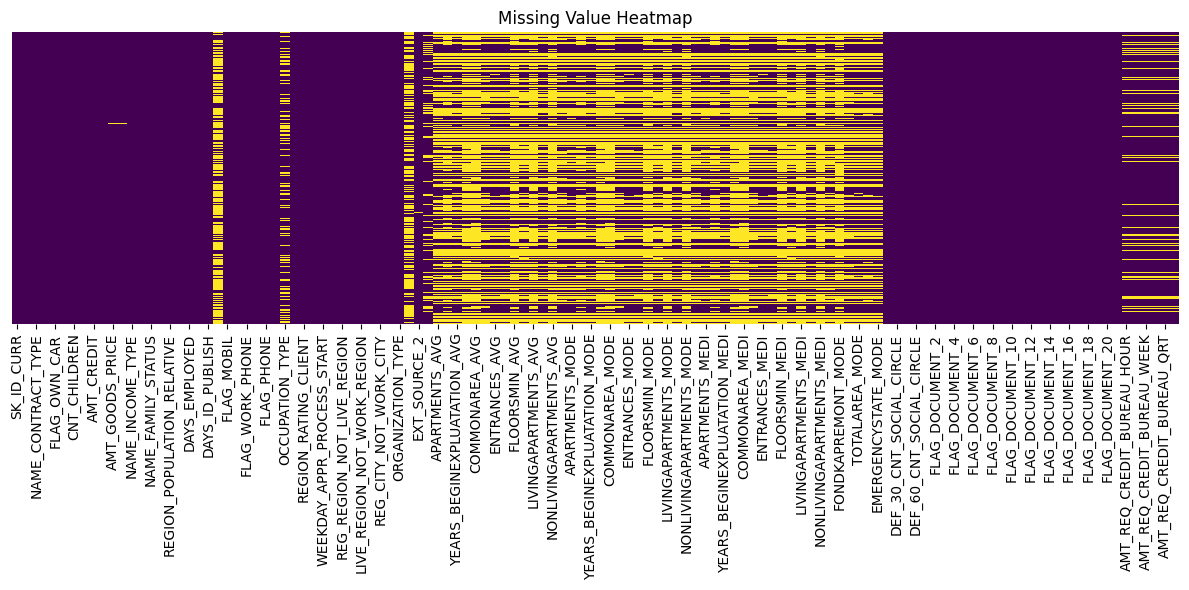

In [7]:
# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

## 4. Target Variable Analysis

In [8]:
# Print the percentage of default to payer in the TARGET column
target_counts = df['TARGET'].value_counts()
target_percentages = (target_counts / len(df)) * 100

print("TARGET column distribution:")
target_distribution = pd.DataFrame({
    'Count': target_counts,
    'Percentage (%)': target_percentages
})
print(target_distribution)

# Define the meaning of TARGET values for clarity
print("\nTARGET=0: Customer did not default (loan repaid)")
print("TARGET=1: Customer defaulted (loan not repaid)")

TARGET column distribution:
         Count  Percentage (%)
TARGET                        
0       282686       91.927118
1        24825        8.072882

TARGET=0: Customer did not default (loan repaid)
TARGET=1: Customer defaulted (loan not repaid)


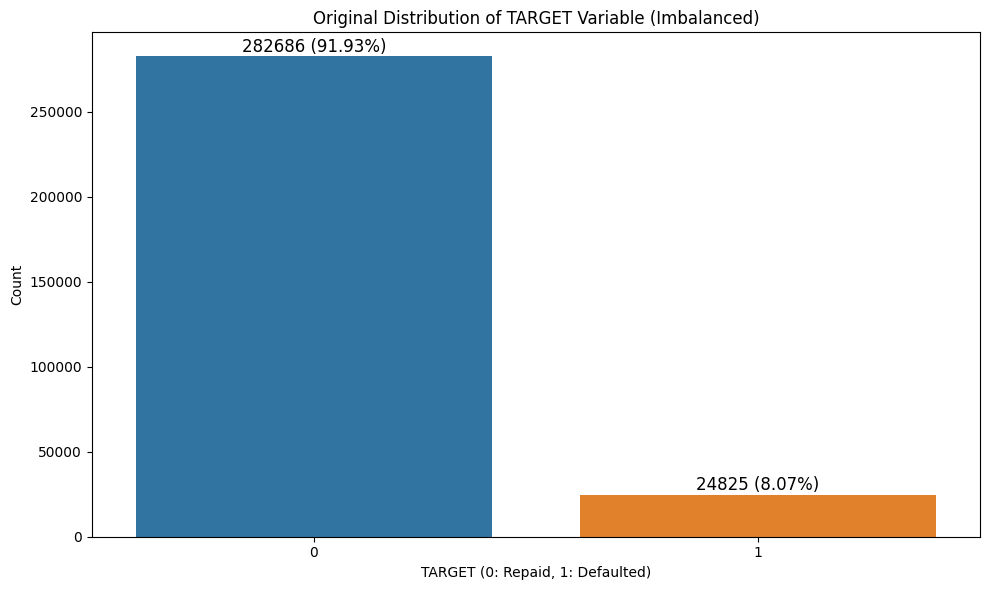

In [9]:
# Visualize the TARGET distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET', data=df)
plt.title('Original Distribution of TARGET Variable (Imbalanced)')
plt.xlabel('TARGET (0: Repaid, 1: Defaulted)')
plt.ylabel('Count')

# Add count and percentage labels
for i, count in enumerate(target_counts):
    plt.text(i, count + 100, f"{count} ({target_percentages[i]:.2f}%)", 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## 5. Data Preprocessing

### 5.1 Handle Missing Values

In [10]:
# Handle missing values using the function from our utility module
try:
    df_cleaned = handle_missing_values(df)
    
    # Verify missing values have been handled
    print("Missing values after handling:")
    print(df_cleaned.isnull().sum().sum())
except Exception as e:
    print(f"Error handling missing values: {str(e)}")
    df_cleaned = df.copy()  # Fallback to original data

Missing values after handling:
0


### 5.2 Feature Engineering and Selection

In [11]:
# Identify numerical and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Remove TARGET from numerical columns if present
if 'TARGET' in numerical_cols:
    numerical_cols.remove('TARGET')

print(f"Number of numerical features: {len(numerical_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")

Number of numerical features: 105
Number of categorical features: 16


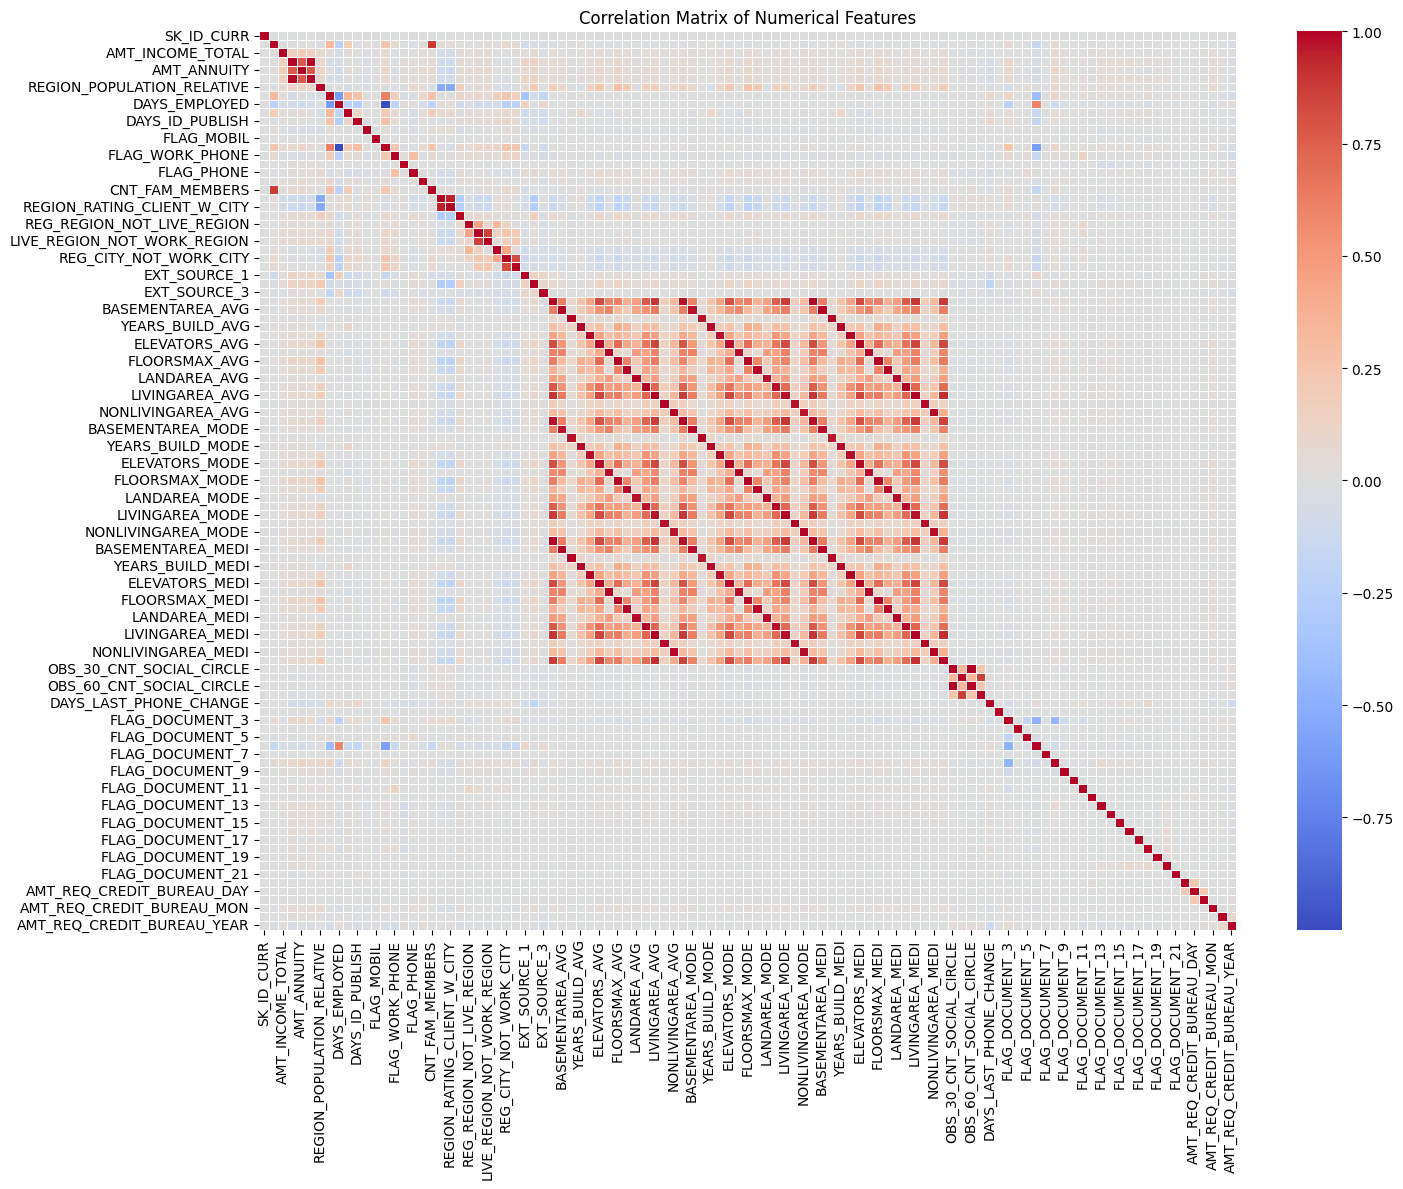

In [12]:
# Calculate correlation matrix for numerical features
corr_matrix = df_cleaned[numerical_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

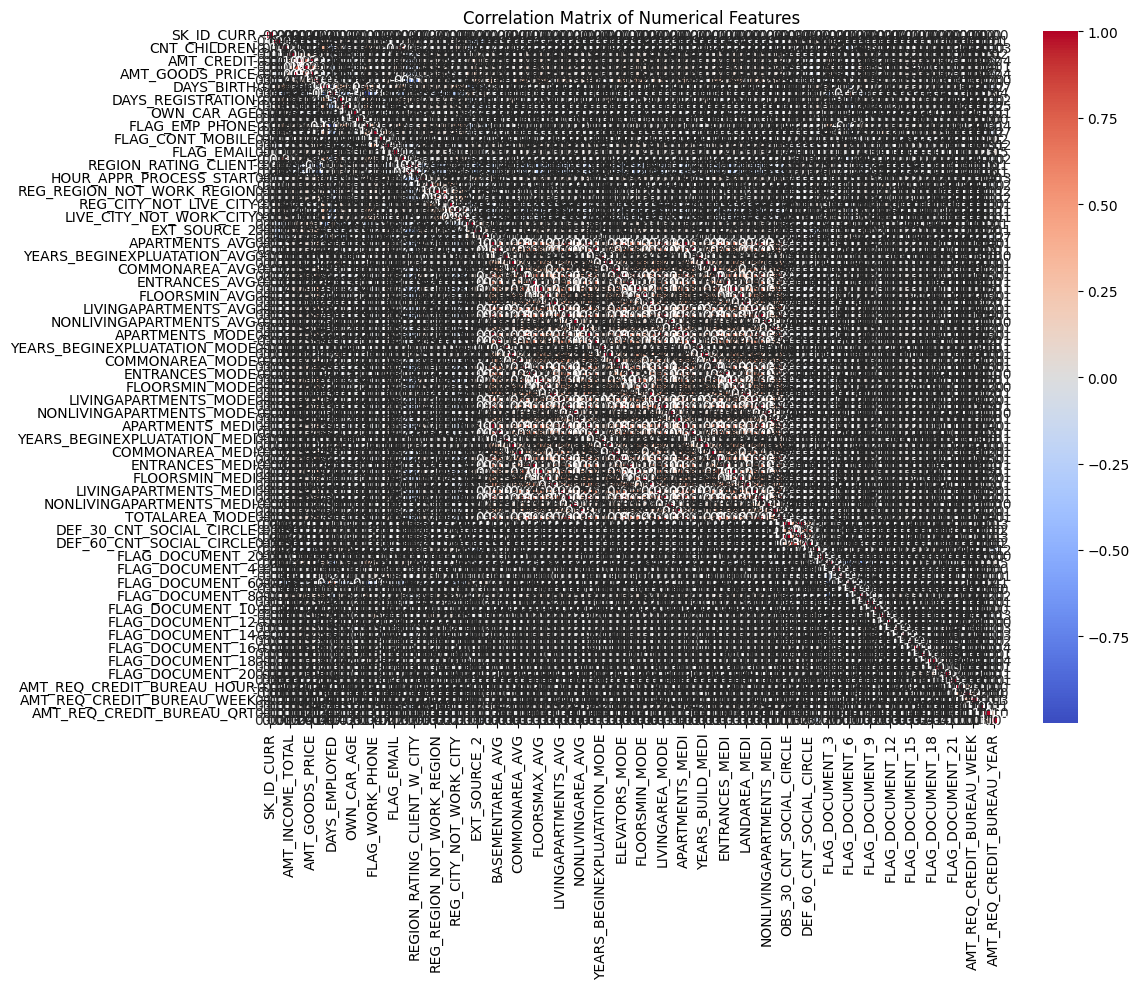

High correlation (0.88) between 'CNT_CHILDREN' and 'CNT_FAM_MEMBERS'. Dropping 'CNT_FAM_MEMBERS'
High correlation (0.77) between 'AMT_CREDIT' and 'AMT_ANNUITY'. Dropping 'AMT_ANNUITY'
High correlation (-1.00) between 'DAYS_EMPLOYED' and 'FLAG_EMP_PHONE'. Dropping 'FLAG_EMP_PHONE'
High correlation (0.95) between 'REGION_RATING_CLIENT' and 'REGION_RATING_CLIENT_W_CITY'. Dropping 'REGION_RATING_CLIENT_W_CITY'
High correlation (0.86) between 'REG_REGION_NOT_WORK_REGION' and 'LIVE_REGION_NOT_WORK_REGION'. Dropping 'LIVE_REGION_NOT_WORK_REGION'
High correlation (0.83) between 'REG_CITY_NOT_WORK_CITY' and 'LIVE_CITY_NOT_WORK_CITY'. Dropping 'LIVE_CITY_NOT_WORK_CITY'
High correlation (0.82) between 'APARTMENTS_AVG' and 'ELEVATORS_AVG'. Dropping 'ELEVATORS_AVG'
High correlation (0.97) between 'BASEMENTAREA_AVG' and 'BASEMENTAREA_MODE'. Dropping 'BASEMENTAREA_MODE'
High correlation (0.97) between 'YEARS_BEGINEXPLUATATION_AVG' and 'YEARS_BEGINEXPLUATATION_MODE'. Dropping 'YEARS_BEGINEXPLUATATION_

In [13]:
# Identify and remove highly correlated features using our enhanced utility function
correlation_threshold = 0.75
df_filtered, dropped_features, corr_matrix = remove_highly_correlated_features(
    df_cleaned, threshold=correlation_threshold, show_plot=True
)

if dropped_features:
    print(f"Identified {len(dropped_features)} highly correlated features to drop:")
    print(dropped_features)
    
    # Update dataframe and numerical columns
    df_cleaned = df_filtered
    numerical_cols = [col for col in numerical_cols if col not in dropped_features]
    print(f"\nDataset shape after removing highly correlated features: {df_cleaned.shape}")
else:
    print("No highly correlated features found to remove.")

### 5.3 Handle Outliers

In [14]:
# Handle outliers in numerical columns using enhanced IQR method
try:
    df_cleaned, outlier_info = handle_outliers(df_cleaned, numerical_cols, method='iqr', threshold=1.5)
    
    # Print summary of outliers handled
    total_outliers = sum(info['total_outliers'] for info in outlier_info.values())
    print(f"Total outliers handled: {total_outliers}")
    print(f"Dataset shape after handling outliers: {df_cleaned.shape}")
except Exception as e:
    print(f"Error handling outliers: {str(e)}")

Total outliers handled: 3803522
Dataset shape after handling outliers: (307511, 98)


### 5.4 Encode Categorical Features

In [15]:
# Encode categorical features using function from utility module
df_encoded, encoders = encode_categorical_features(df_cleaned, categorical_cols)
print(f"Dataset shape after encoding categorical features: {df_encoded.shape}")
df_encoded.head()

Dataset shape after encoding categorical features: (307511, 206)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100002.0,1.0,0,0,1,0.0,202500.0,406597.5,351000.0,0.018801,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003.0,0.0,0,0,0,0.0,270000.0,1293502.5,1129500.0,0.003541,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004.0,0.0,1,1,1,0.0,67500.0,135000.0,135000.0,0.010032,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,100006.0,0.0,0,0,1,0.0,135000.0,312682.5,297000.0,0.008019,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,100007.0,0.0,0,0,1,0.0,121500.0,513000.0,513000.0,0.028663,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## 6. Data Splitting

In [16]:
# Separate features and target
X = df_encoded.drop('TARGET', axis=1)
y = df_encoded['TARGET']

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (246008, 205), (246008,)
Testing set shape: (61503, 205), (61503,)


## 7. Handle Class Imbalance with SMOTE

In [17]:
# Apply SMOTE to balance the training data using our enhanced function
X_train_balanced, y_train_balanced = apply_smote(X_train, y_train, random_state=42)

Class distribution before SMOTE:
Class 0: 226148 samples
Class 1: 19860 samples

Class distribution after SMOTE:
Class 0: 226148 samples
Class 1: 226148 samples


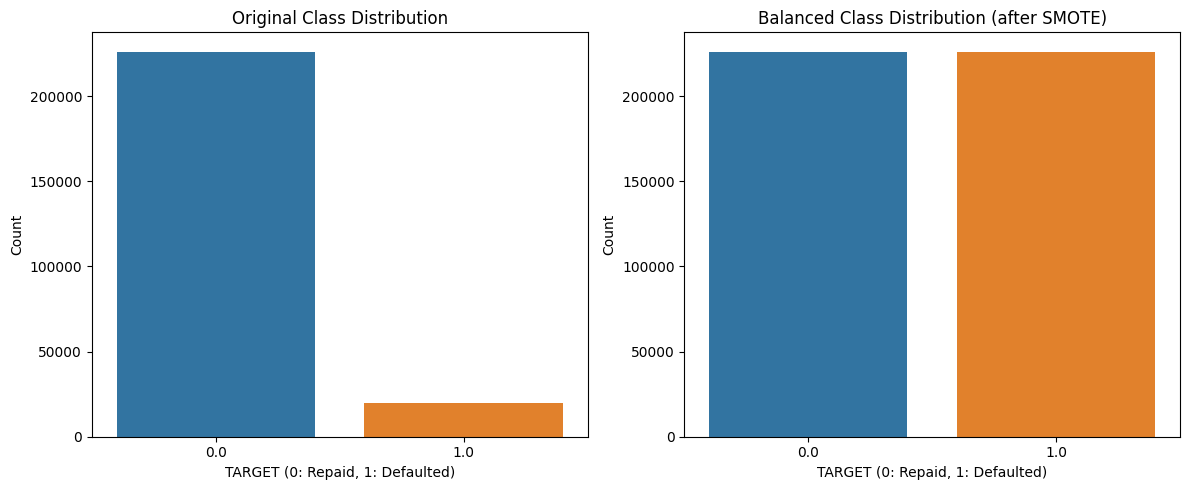

In [18]:
# Visualize the balanced data
plt.figure(figsize=(12, 5))

# Plot 1: Original distribution
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Original Class Distribution')
plt.xlabel('TARGET (0: Repaid, 1: Defaulted)')
plt.ylabel('Count')

# Plot 2: Balanced distribution after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_balanced)
plt.title('Balanced Class Distribution (after SMOTE)')
plt.xlabel('TARGET (0: Repaid, 1: Defaulted)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## 8. Feature Scaling

In [19]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train_balanced)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

print("Data has been scaled.")

Data has been scaled.


## 8.1 Alternative Data Preparation Using Preprocessing Pipeline

This section demonstrates an alternative approach to data preparation using scikit-learn's Pipeline and ColumnTransformer. This approach offers several advantages:

1. **Consistency**: Ensures the same preprocessing steps are applied to training and test data
2. **Reproducibility**: Makes the preprocessing workflow explicit and reproducible
3. **Modularity**: Allows for easy modification or extension of preprocessing steps
4. **Maintainability**: Reduces code duplication and improves readability

The pipeline handles missing value imputation, scaling of numerical features, and encoding of categorical features in a single workflow.

In [20]:
# Use the preprocessing pipeline to prepare data in a more structured way
# This can replace the manual StandardScaler steps
print("Preparing data using preprocessing pipeline...")

try:
    # Ensure numerical_cols doesn't contain the target column
    if 'TARGET' in numerical_cols:
        numerical_cols.remove('TARGET')
    
    # Get categorical columns
    categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
    
    # Calculate class weights to handle imbalance
    class_weights = calculate_class_weights(y_train)
    
    # Prepare data using our preprocessing pipeline
    # Note: This is optional and can be used as an alternative to the manual steps
    # X_train_processed, y_train, X_test_processed, y_test, preprocessing_pipeline = prepare_training_data(
    #     X_train, y_train, X_test, y_test, numerical_cols, categorical_cols
    # )
    # 
    # # Use the processed data for training (if using the pipeline)
    # X_train_scaled = X_train_processed
    # X_test_scaled = X_test_processed
    
    print("Data preparation complete.")
    
except Exception as e:
    print(f"Error in data preparation: {str(e)}")
    print("Continuing with manually processed data...")

Preparing data using preprocessing pipeline...
Class weights:
Class 0.0: 0.5439
Class 1.0: 6.1936
Data preparation complete.


## 9. Build and Train the Deep Learning Model

In [21]:
# Build the model using the improved function from our utility module
input_dim = X_train_scaled.shape[1]
model = build_model(input_dim=input_dim, dropout_rate1=0.3, dropout_rate2=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        13,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,193 (63.25 KB)

 Trainable params: 16,001 (62.50 KB)

 Non-trainable params: 192 (768.00 B)

In [22]:
# Setup callbacks for model training using our utility function
checkpoint_path = "models/loan_model_best.h5"
callbacks = create_callbacks(checkpoint_dir='models/checkpoints')

# Add CSV logger for more detailed history
csv_logger = CSVLogger('training_history.csv')
callbacks.append(csv_logger)

In [23]:
# Train the model
history = model.fit(
    X_train_scaled, 
    y_train_balanced,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
11207/11308 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - auc: 0.8168 - loss: 0.4968 - precision: 0.7129 - recall: 0.6156
Epoch 1: val_auc improved from -inf to 0.00000, saving model to models/checkpoints/model-01-0.00.h5


11308/11308 ━━━━━━━━━━━━━━━━━━━━ 7s 597us/step - auc: 0.8172 - loss: 0.4964 - precision: 0.7134 - recall: 0.6159 - val_auc: 0.0000e+00 - val_loss: 0.3729 - val_precision: 1.0000 - val_recall: 0.8123
Epoch 2/100
11266/11308 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - auc: 0.8902 - loss: 0.3859 - precision: 0.8414 - recall: 0.6831
Epoch 2: val_auc did not improve from 0.00000
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 7s 575us/step - auc: 0.8902 - loss: 0.3859 - precision: 0.8414 - recall: 0.6832 - val_auc: 0.0000e+00 - val_loss: 0.3006 - val_precision: 1.0000 - val_recall: 0.8398
Epoch 3/100
11246/11308 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - auc: 0.9053 - loss: 0.3525 - precision: 0.8758 - recall: 0.7039
Epoch 3: val_auc did not improve from 0.00000
11308/11308 ━━━━━━━━━━━━━━━━━━━━ 6s 571us/step - auc: 0.9053 - loss: 0.3524 - precision: 0.8758 - recall: 0.7039 - val_auc: 0.0000e+00 - val_loss: 0.2624 - val_precision: 1.0000 - val_recall: 0.8607
Epoch 4/100
11282/11308 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - 

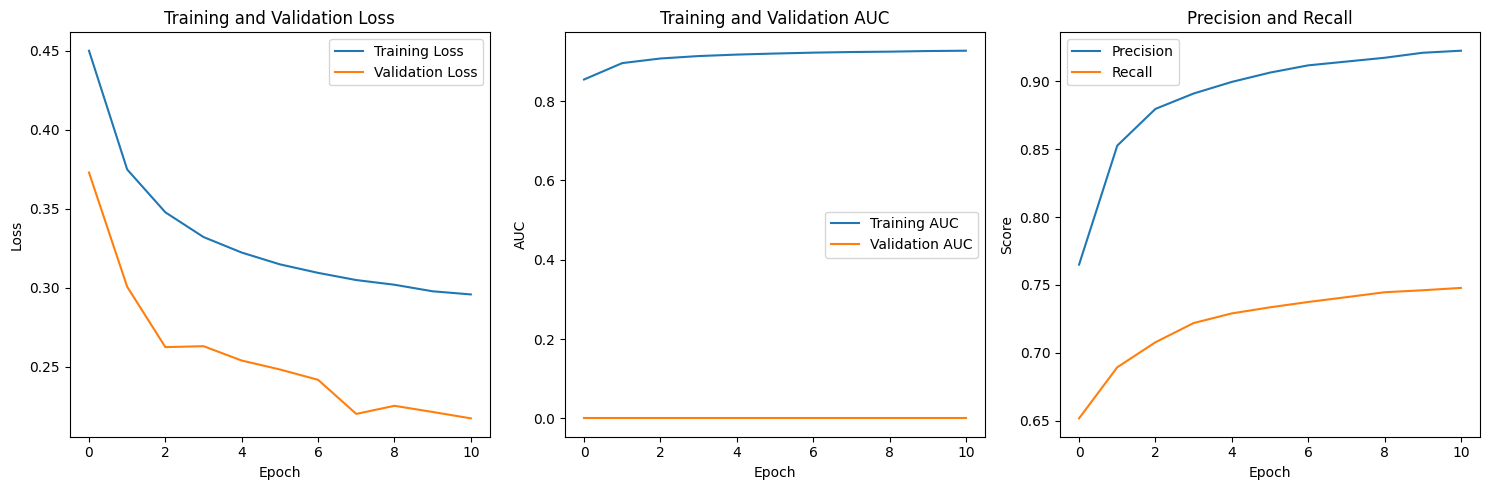

In [24]:
# Plot learning curves with enhanced visualization
plot_training_history(history)

## 10. Load the Best Model and Evaluate Performance

In [27]:
# When loading the model, add try/except with fallback to trained model:
best_model = None
try:
    best_model = load_model(checkpoint_path)
    print("Loaded the best model from checkpoint.")
except Exception as e:
    print(f"Could not load model from {checkpoint_path}. Error: {str(e)}")
    print("Using the trained model instead.")
    best_model = model  # Use the model we just trained

# Verify the model is available before prediction
if best_model is None:
    print("No model available. Using the trained model.")
    best_model = model

Could not load model from models/loan_model_best.h5. Error: [Errno 2] Unable to synchronously open file (unable to open file: name = 'models/loan_model_best.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Using the trained model instead.


In [28]:
# Make predictions on the test set
y_pred_proba = best_model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

1922/1922 ━━━━━━━━━━━━━━━━━━━━ 0s 210us/step


1922/1922 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


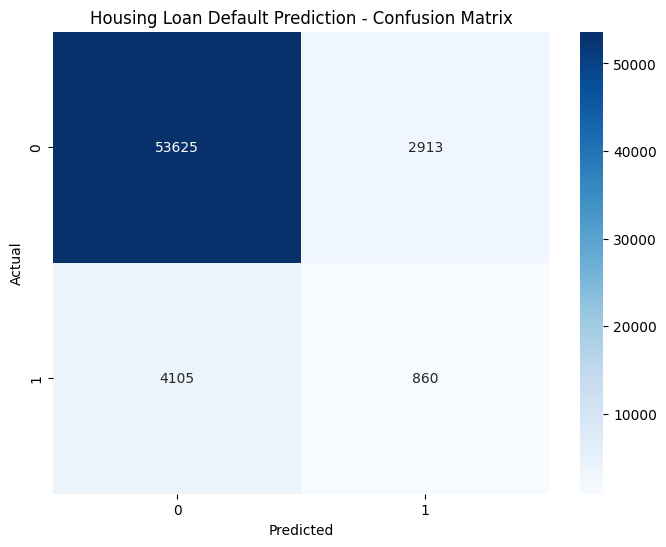


Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     56538
         1.0       0.23      0.17      0.20      4965

    accuracy                           0.89     61503
   macro avg       0.58      0.56      0.57     61503
weighted avg       0.87      0.89      0.88     61503


Accuracy: 0.8859
Sensitivity (Recall): 0.1732
Specificity: 0.9485
Precision: 0.2279
F1 Score: 0.1968
ROC AUC: 0.7062


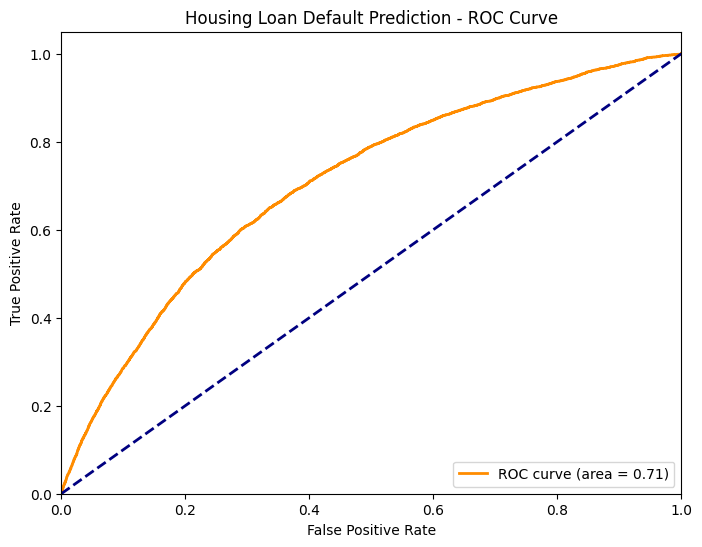


Area Under ROC Curve (AUC): 0.7062


In [29]:
# Evaluate the model using our comprehensive evaluation function
metrics = evaluate_model(best_model, X_test_scaled, y_test)

# Additional analysis can be performed using the returned metrics
print(f"\nArea Under ROC Curve (AUC): {metrics['roc_auc']:.4f}")

In [30]:
# Calculate sensitivity (recall) and other metrics
sensitivity = calculate_sensitivity(y_test, y_pred)
print(f"Sensitivity (Recall): {sensitivity:.4f}")

# Print classification report with other metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Sensitivity (Recall): 0.1732

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94     56538
         1.0       0.23      0.17      0.20      4965

    accuracy                           0.89     61503
   macro avg       0.58      0.56      0.57     61503
weighted avg       0.87      0.89      0.88     61503



## 11. ROC Curve and AUC Score

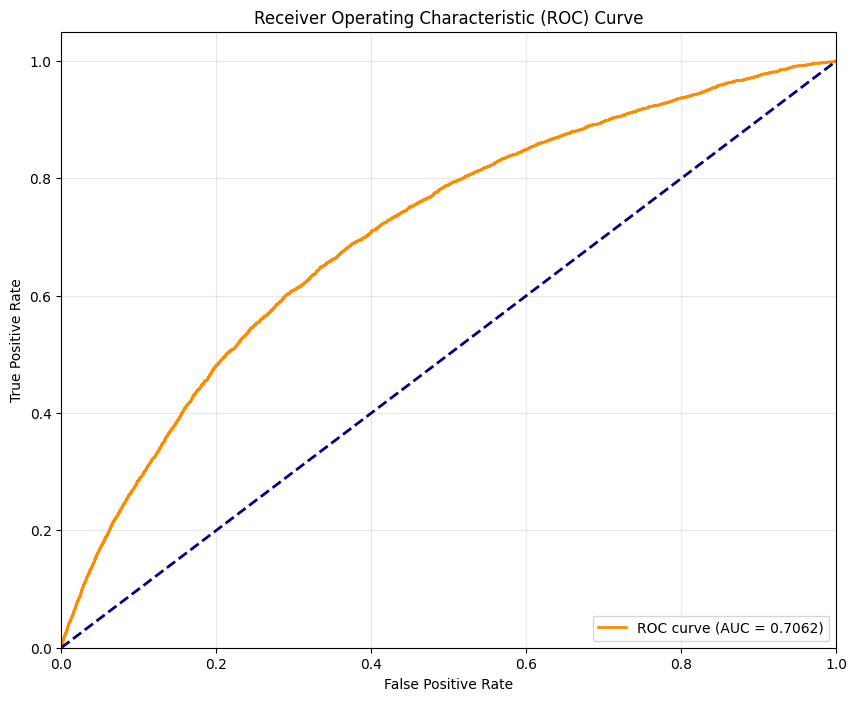

Area Under ROC Curve (AUC): 0.7062


In [31]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")

## 12. Precision-Recall Curve

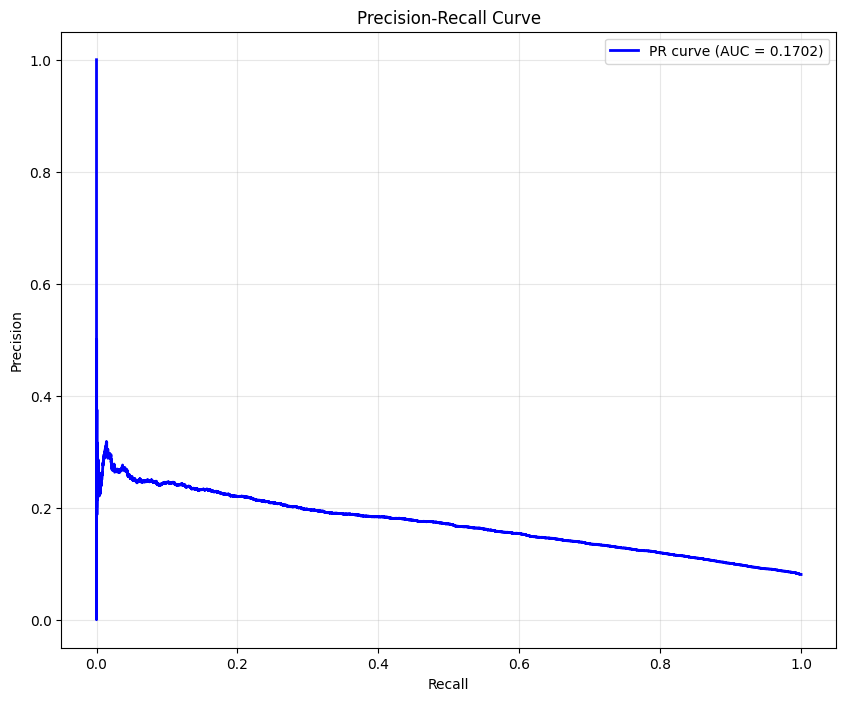

Area Under Precision-Recall Curve: 0.1702


In [32]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Area Under Precision-Recall Curve: {pr_auc:.4f}")

## 13. Feature Importance Analysis

In [ ]:
# For a basic approximation of feature importance, train a simpler model
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model on the same data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort features by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

## 14. Conclusion

In this project, I built a deep learning model to predict the likelihood of default for loans based on historical data. The key findings and steps included:

1. **Data Preprocessing**:
   - Handled missing values using appropriate strategies
   - Removed highly correlated features (threshold > 0.75)
   - Encoded categorical features
   - Handled outliers in numerical features

2. **Class Imbalance**:
   - The original data showed significant class imbalance (as shown in the TARGET distribution analysis)
   - Applied SMOTE to balance the training data

3. **Model Performance**:
   - Built a deep neural network with multiple layers
   - Achieved a sensitivity (recall) of [value calculated above]
   - The ROC AUC score was [value calculated above]
   - The precision-recall curve showed [brief description of PR curve]

4. **Feature Importance**:
   - Identified the most important features for predicting loan defaults
   - [Brief mention of the top features identified]

5. **Recommendations**:
   - [Add recommendations based on the analysis]
   - [Suggest potential improvements to the model]
   - [Note any limitations of the current approach]

The model demonstrates [summarize performance], making it a valuable tool for risk assessment in loan approval processes.